In [125]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as ss
import tensorflow as tf
import math
import random

Parameter initialization

In [196]:
T=30/365
dt=1/365
N=round(T/dt)
t=np.linspace(0,T,N)
vol=0.2
r=0
cost=0.002
S0=100

Generated sample paths by GBM model

In [197]:
path_num=300  #We set the number of the sample paths. Here we choose 300 for the sake of simplicity
path=[]
for i in range(path_num):
    rand=np.random.standard_normal(size=N)
    S=np.zeros_like(rand)
    S[0]=S0
    for i in range(1,N):
        S[i]=S[i-1]*np.exp((r-vol**2/2)*dt+vol*rand[i]*math.sqrt(dt))
    path.append(S)

In [198]:
path=np.array(path)

Visualized one of the sample

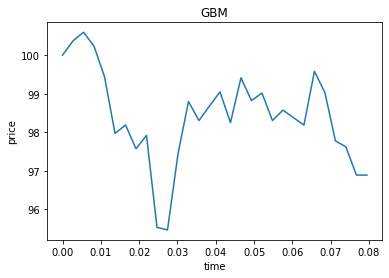

In [199]:
S_sam=path[0]
time=range(len(S_sam))
time=np.array(time)/365
plt.xlabel('time')
plt.ylabel('price')
plt.title(u'GBM')
plt.plot(time,S_sam)
plt.show()

Calculated the option prices

In [200]:
path_diff=[]
for i in range(path_num):    
    S_diff=[]
    S_tem=path[i]
    for i in range(1,len(S_tem)):
        S_diff.append(S_tem[i]-S_tem[i-1])
    S_diff=np.array(S_diff)
    #S_diff=S_diff.reshape(-1,1)
    S_diff=np.float32(S_diff)
    path_diff.append(S_diff)
path_dif=np.array(path_diff)
path_dif.shape

(300, 29)

In [201]:
from math import log,sqrt,exp
from scipy.stats import norm

In [202]:
rever_t=sorted(range(N),reverse=True)
rever_t=rever_t[:-1]
rever_t=np.array(rever_t)/365
rever_t

array([0.07945205, 0.07671233, 0.0739726 , 0.07123288, 0.06849315,
       0.06575342, 0.0630137 , 0.06027397, 0.05753425, 0.05479452,
       0.05205479, 0.04931507, 0.04657534, 0.04383562, 0.04109589,
       0.03835616, 0.03561644, 0.03287671, 0.03013699, 0.02739726,
       0.02465753, 0.02191781, 0.01917808, 0.01643836, 0.01369863,
       0.0109589 , 0.00821918, 0.00547945, 0.00273973])

In [203]:
def call_option_pricer(spot,strike,maturity,r,vol):
    d1=(log(spot/strike)+(r+0.5*vol*vol)*maturity)/(vol*sqrt(maturity))
    d2=d1-vol*sqrt(maturity)
    price=spot*norm.cdf(d1)-strike*exp(-r*maturity)*norm.cdf(d2)
    return price

In [204]:
%%time
Option_sam=[]
for i in range(path_num):
    S=path[i]
    Option=[]
    for j in range(len(S)-1):
        price=call_option_pricer(S[j],100,rever_t[j],r,vol)
        Option.append(price)
    Option.append(max(S[-1]-S0,0))
    Option=np.array(Option)
    #Option=Option.reshape(-1,1)
    Option_sam.append(Option)


Wall time: 1.13 s


In [205]:
Option_samp=np.array(Option_sam)
Option_samp.shape

(300, 30)

In [206]:
Nd_nor=[]
for j in range(path_num):    
    d_nor=[]
    for i in range(len(rever_t)):
        par1=1.0/(vol*math.sqrt(rever_t[i]))
        par2=np.log(path[j][i]/S0)
        par3=(r+(vol**2)/2)*(rever_t[i])
        Nd=par1*(par2+par3)
        d_nor.append(ss.norm.cdf(Nd))
    Nd_nor.append(d_nor)

In [207]:
hedge_set=[]
for i in range(path_num):
    hedge=[Option_samp[i][0].tolist()]
    for j in range(len(Nd_nor[i])):
        diff=path[i][j+1]-path[i][j]
        hold=Nd_nor[i][j]*diff
        hedge.append(hold)
    
    hedge=np.cumsum(hedge).tolist()
    hedge_set.append(hedge)
    

In [208]:
hedge_set=np.array(hedge_set)

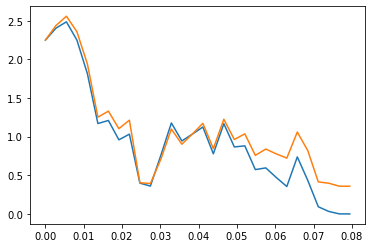

In [209]:
plt.plot(time,Option_samp[0])
plt.plot(time,hedge_set[0])
plt.show()

In [210]:
su1=0
num=0
for j in range(path_num):
    for i in range(len(Option_samp[int(j)])):
        k=Option_samp[int(j)][i].tolist()-hedge_set[int(j)][i]
        j=k**2
        su1+=j
        num+=1
su1/num

0.041064787492770344

Deep neural network for hedging without transaction cost

In [211]:
x_train=path[:,:-1]
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_train.shape

(300, 29, 1)

In [212]:
import tensorflow as tf

In [220]:
RNN_CELLSIZE = 50
SEQLEN = x_train.shape[1]
BATCHSIZE = 1
LR = 0.001

In [221]:
class GRUModel(tf.keras.Model):
    def __init__(self, batch_size, seq_length, cell_size):
        super().__init__()
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.cell_size = cell_size
    
        self.layer1 = tf.keras.layers.Reshape((self.seq_length,1), batch_size = self.batch_size)
        self.layer_GRU = tf.keras.layers.GRU(self.cell_size,activation='relu',return_sequences=True)
        self.layer_GRU_last = tf.keras.layers.GRU(50,activation='relu')
        self.layer_dense = tf.keras.layers.Dense(29)
  
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer_GRU(x)
        x = self.layer_GRU_last(x)
        output = self.layer_dense(x)
        return output

In [215]:
Option_samp.shape

(300, 30)

In [216]:
def loss_function1(x,S_diff,option):
    diff=[]
    for j in range(option.shape[0]):        
        a=[option[j][0]]
        for i in range(len(x[j])):
            add=x[j][i]*S_diff[j][i]
            a.append(add)
        d=tf.cumsum(a)
        b=option[j]-d
        c=tf.abs(b[-1])
        diff.append(c)
    return diff

In [442]:
di=loss_function1(Nd_nor,path_diff,Option_samp)
#di

Used Expected Shortfall as loss functions

In [149]:
def loss_fun1(price):
    res=0
    for i in range(len(price)):
        e=np.percentile(price[i],50)
        ES=0
        n=0
        for j in range(len(price[i])):
            if tf.greater(price[i][j],e):
                ES+=price[i][j]
                n+=1
        ES1=ES/n
        res+=ES1
    res1=res/len(price)
    return res1

Used a weighted average of Expected Shortfall with different parameters as a loss function

In [25]:
def loss_fun3(price):
    res=0
    for i in range(len(price)):
        e1=np.percentile(price[i],50)
        e2=np.percentile(price[i],95)
        beta=0.05
        ES1=0
        ES2=0
        m=0
        n=0
        for j in range(len(price[i])):
            if tf.greater(price[i][j],e1):
                ES1+=price[i][j]
                n+=1
            if tf.greater(price[i][j],e2):
                ES2+=price[i][j]
                m+=1
        ES11=ES1/n
        ES21=ES2/m
        con=(1.0/(1+beta))*(ES11+beta*ES21)
        res+=con
    res1=res/len(price)
    return res1

In [62]:
def loss_fun2(price):
    hold=[]
    for i in range(len(price)):
        for j in range(len(price[i])):
            hold.append(price[i][j])
    e1=np.percentile(hold,95)
    e2=np.percentile(hold,50)
    beta=0.05
    ES1=0
    ES2=0
    m=0
    n=0
    for j in range(len(hold)):
        if tf.greater(hold[j],e1):
            ES1+=hold[j]
            n+=1
        if tf.greater(hold[j],e2):
            ES2+=hold[j]
            m+=1
    ES11=ES1/n
    ES21=ES2/m
    con=(1.0/(1+beta))*(ES11+beta*ES21)
    return con

In [222]:
model = GRUModel(BATCHSIZE, SEQLEN,RNN_CELLSIZE)
optimizer = tf.keras.optimizers.Adam(learning_rate = LR)

In [223]:
for epoch in range(150):
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        #print(y_pred)
        price=loss_function1(y_pred, path_diff,Option_samp)
        loss=loss_fun3(price)
        if epoch%1 == 0:
            print("epoch: {}, loss: {}".format(epoch, loss))
  
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads,model.variables))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch: 0, loss: 14.44222354888916
epoch: 1, loss: 12.844446182250977
epoch: 2, loss: 11.48932933807373
epoch: 3, loss: 10.316974639892578
epoch: 4, loss: 9.274782180786133
epoch: 5, loss: 8.35815143585205
epoch: 6, loss: 7.542582035064697
epoch: 7, loss: 6.8206467628479
epoch: 8, loss: 6.205434322357178
epoch: 9, loss: 5.6686530113220215
epoch: 10, loss: 5.183105945587158
epoch: 11, loss: 4.773231029510498
epoch: 12, loss: 4.45538854598999
epoch: 13, loss: 4.208028793334961
epoch: 14, loss: 4.0380625724

test sample

In [521]:
test_num=500  #We could set the number of test samples. Here we choose 500 test samples
test_path=[]
for i in range(test_num):
    rand=np.random.standard_normal(size=N)
    S=np.zeros_like(rand)
    S[0]=S0
    for i in range(1,N):
        S[i]=S[i-1]*np.exp((r-vol**2/2)*dt+vol*rand[i]*math.sqrt(dt))
    test_path.append(S)

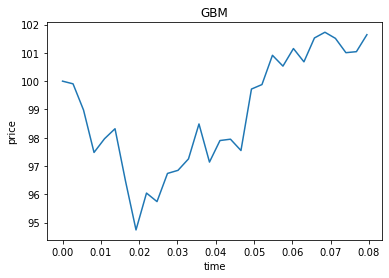

In [522]:
test_S_sam=test_path[0]
time=range(len(test_S_sam))
time=np.array(time)/365
plt.xlabel('time')
plt.ylabel('price')
plt.title(u'GBM')
plt.plot(time,test_S_sam)
plt.show()

In [523]:
test_path=np.array(test_path)
test_path.shape

(500, 30)

Black-Scholes Model hedge

In [524]:
def call_option_price(spot,strike,maturity,r,vol):
    pricer=[]
    for i in range(len(spot)):
        pricer1=[]
        for j in range(len(spot[i])-1):
            spot1=spot[i][j]
            d1=(log(spot1/strike)+(r+0.5*vol*vol)*maturity[j])/(vol*sqrt(maturity[j]))
            d2=d1-vol*sqrt(maturity[j])
            price=spot1*norm.cdf(d1)-strike*exp(-r*maturity[j])*norm.cdf(d2)
            pricer1.append(price)
        pricer1.append(max(spot[i][-1]-100,0))
        pricer.append(pricer1)
    pricer=np.array(pricer)
    return pricer

In [525]:
%%time
test_Option_sam=call_option_price(test_path,100,rever_t,r,vol)
test_Option_sam

Wall time: 1.87 s


In [526]:
len(test_Option_sam)

500

In [527]:
def hedge_ratio(path_num,rever_t,path,S0,vol,r):
    te=[]
    for j in range(path_num):    
        d_nor=[]
        for i in range(len(rever_t)):
            par1=1.0/(vol*math.sqrt(rever_t[i]))
            par2=np.log(path[j][i]/S0)
            par3=(r+(vol**2)/2)*(rever_t[i])
            Nd=par1*(par2+par3)
            d_nor.append(ss.norm.cdf(Nd))
        te.append(d_nor)
    return te

In [528]:
test_Nor=hedge_ratio(test_num,rever_t,test_path,S0,vol,r)


In [529]:
len(test_Nor)

500

In [530]:
def hedge_set1(path_num,rever_t,Option_samp,Nd_nor,path):
    hedge_set=[]
    for i in range(path_num):
        hedge=[Option_samp[i][0].tolist()]
        for j in range(len(Nd_nor[i])):
            diff=path[i][j+1]-path[i][j]
            hold=Nd_nor[i][j]*diff
            hedge.append(hold)
    
        hedge=np.cumsum(hedge).tolist()
        hedge_set.append(hedge)
    hedge_set=np.array(hedge_set)
    return hedge_set


In [531]:
test_hedge=hedge_set1(test_num,rever_t,test_Option_sam,test_Nor,test_path)

In [532]:
test_hedge.shape

(500, 30)

Example of Black-Scholes Model hedge

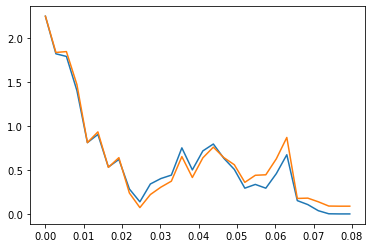

In [533]:
plt.plot(time,test_Option_sam[15])
plt.plot(time,test_hedge[15])
plt.show()

Mean squared hedging loss of Black-Scholes Model hedge

In [534]:
su1=0
num=0
hist_model=[]
for j in range(test_num):
    for i in range(len(test_Option_sam[int(j)])):
        k=test_Option_sam[int(j)][i].tolist()-test_hedge[int(j)][i]
        hist_model.append(k)
        err=k**2
        su1+=err
        num+=1
su1/num

0.051060322131737106

network hedge

In [535]:
y_test=model.predict(test_path[:,:-1])

In [536]:
y_test.shape

(500, 29)

In [537]:
op_te=hedge_set1(test_num,rever_t,test_Option_sam,y_test,test_path)

Example of the network hedge

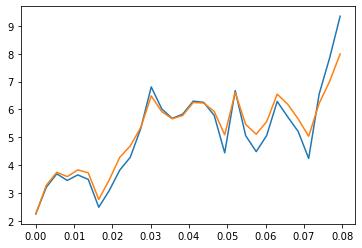

In [538]:
plt.plot(time,test_Option_sam[16])
plt.plot(time,op_te[16])
plt.show()

In [539]:
op_te.shape

(500, 30)

Mean squared hedging loss of network hedge

In [540]:
su1=0
num=0
hist_model1=[]
for j in range(test_num):
    for i in range(len(test_Option_sam[int(j)])):
        k=test_Option_sam[int(j)][i].tolist()-op_te[int(j)][i]
        hist_model1.append(k)
        err=k**2
        su1+=err
        num+=1
su1/num

0.42756072210871315

Distribution of hedging error of Black-Scholes Model hedge

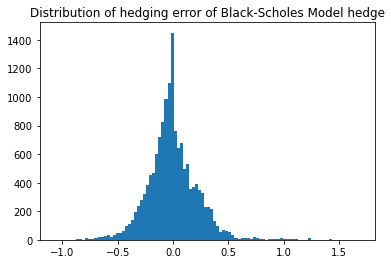

In [543]:
plt.hist(hist_model,bins=100)  #Distribution of hedging error of Black-Scholes Model hedge
plt.title('Distribution of hedging error of Black-Scholes Model hedge')
plt.show()

Distribution of hedging error of network hedge

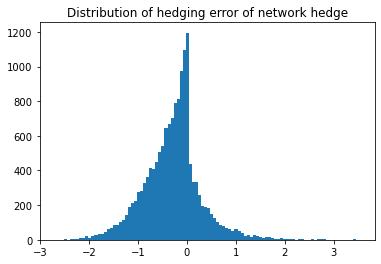

In [544]:
plt.hist(hist_model1,bins=100)  #Distribution of hedging error of network hedge
plt.title('Distribution of hedging error of network hedge')  
plt.show()

Since we only simulate 300 sample paths as training samples, the mean squared hedging loss of network hedge is a bit larger than that of Black-Scholes Model hedge. With the increasing number of training samples, network hedge will be able to replicate the Black-Scholes hedge reasonably well and even outperforms the Black-Scholes hedge.